In [1]:
import torch
import json
import numpy as np
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from lbfgs import FullBatchLBFGS
from utils import reparametrized_expanded_params, init_random_params
import matplotlib.pyplot as plt

In [2]:
##############" LOADING Arguments" ################

nq = 3 #enter nb of row classes
nl = 5 #enter nb of col classes
device = 'mps' #put 'cuda' or 'cpu'
device2 = 'mps' #put None or 'cuda'

if not torch.backends.mps.is_available() and device != 'cpu':
    print('Cuda is not available. Algorithm will use cpu')
    device, device2 = torch.device('cpu'), None

In [3]:
##############" LOADING DATASET" ################

votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)

deputes = json.load(open('data_parliament/deputes.json', 'r')) 
#deputes: Dataset with: Family name, Name, Political group 
texts = json.load(open('data_parliament/texts.json', 'r'))
#texts: Dataset with: political group demanding, title of demand, date, type (type of vote, type of majority, name of type of vote), 
n1, n2 = votes.shape 
# shape of dataset: 
print("row length (nb of persons): ",n1)
print("col length (nb of laws): ",n2)

row length (nb of persons):  576
col length (nb of laws):  1256


In [4]:
##############" Initialization " ################
vector_of_parameters = torch.tensor(init_random_params(n1, n2, nq, nl), requires_grad=True, device=device, dtype=torch.float32)

In [5]:
##############" Model creation "################
model = LBM_NMAR(
    vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

In [6]:
try:
    success, loglike = train_with_LBFGS(model)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  3
Number of col classes :  5
 EM step  |   LBFGS iter  | criteria |


/Users/laurafuentesvicente/M2 Maths&IA/Methodes Non Supervises avancees/Projet/LBM-MNAR/lbfgs.py:339: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1519.)
  p.data.add_(


 0  |   1  | 344035.90625 |
 0  |   2  | 326288.68750 |
 0  |   3  | 320187.90625 |
 0  |   4  | 317128.93750 |
 0  |   5  | 315754.06250 |
 0  |   6  | 315204.12500 |
 0  |   7  | 314732.68750 |
 0  |   8  | 314479.46875 |
 0  |   9  | 314278.90625 |
 0  |   10  | 314056.28125 |
 0  |   11  | 313848.78125 |
 0  |   12  | 313624.25000 |
 0  |   13  | 313262.43750 |
 0  |   14  | 312919.59375 |
 0  |   15  | 312527.28125 |
 0  |   16  | 311966.62500 |
 0  |   17  | 311528.00000 |
 0  |   18  | 310957.43750 |
 0  |   19  | 310764.75000 |
 0  |   20  | 310672.09375 |
 0  |   21  | 310604.34375 |
 0  |   22  | 310589.90625 |
 0  |   23  | 310587.65625 |
 0  |   24  | 310587.34375 |
 0  |   25  | 310587.28125 |
 0  |   26  | 310587.18750 |
Curvature pair skipped due to failed criterion
 0  |   27  | 310587.18750 |
------------------------------  Optimizing next EM step  ------------------------------
 EM step  |   LBFGS iter  | criteria |
 1  |   1  | 308209.71875 |
 1  |   2  | 307036.6875

In [10]:
# Parameters of the model
(   nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)

In [11]:
# Get the row and column classes with the MAP on the varitional distributions
tau_1 = np.array(tau_1.tolist())
tau_2 = np.array(tau_2.tolist())
row_classes = tau_1.argmax(axis=1)
column_classes = tau_2.argmax(axis=1)
print("Texts classes : ", column_classes)
print("MPs classes : ", row_classes)
print([[(deputes[i]['nom'], deputes[i]['groupe']) for i, c in enumerate(row_classes) if c == nq] for nq in range(nq)])

Texts classes :  [1 0 0 ... 1 1 2]
MPs classes :  [2 2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 2 0 1 1 2 2 0 1 1 2 1 1 2 2 2 2 1 2 2 2 2
 2 1 1 2 2 2 2 1 2 1 1 2 2 1 1 1 1 2 2 1 1 2 1 2 1 1 1 2 1 2 2 2 2 1 2 2 2
 1 2 2 1 1 2 2 1 1 1 1 1 1 2 1 1 1 2 1 0 2 2 1 2 0 2 2 1 2 1 1 2 1 1 2 2 2
 1 2 1 2 2 2 2 1 1 1 2 1 1 1 1 1 2 1 1 2 2 2 2 1 2 2 2 1 2 1 1 1 2 1 1 1 2
 2 2 2 2 2 2 1 1 1 2 2 1 2 1 1 1 1 2 2 1 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 1 1
 2 1 2 2 1 2 1 1 2 1 1 2 2 1 1 1 1 2 1 1 2 1 2 1 2 1 1 2 1 2 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 2 1 2 2 2 1 1 2 2 1 2 2 1 1 1 2 2 2 1 2 1 2 2 2 1 2 2 2 1 2
 2 1 1 1 2 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 2 2 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1
 1 2 1 1 2 2 1 2 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 2 2 2 1 2 2 1 2 2 1 1 2 2 2
 2 2 2 2 1 2 2 1 2 2 1 1 2 1 1 2 2 2 1 1 2 2 1 2 2 2 2 1 1 2 1 2 2 1 2 1 2
 2 2 1 2 2 1 2 1 1 2 2 1 1 2 2 2 2 2 1 2 1 1 2 1 1 2 2 1 1 2 2 2 2 2 1 1 1
 1 2 2 1 1 2 2 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 2 1 2 2 1 1 2 1 1 2 2 1 2 1 2
 2 1 1 2 2 1 2 2 1 1 1 0 1 2 2 1 2 1 1 2 2 1 1 1 0

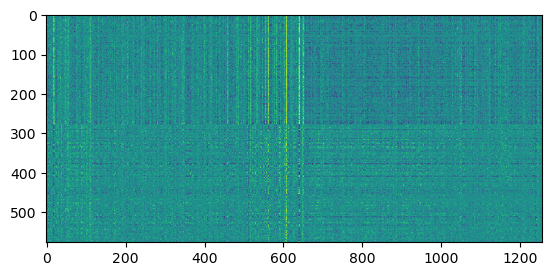

In [12]:
######### Display the vote matrix, rows and columns re-ordered according to their respective classes.
plt.imshow(
    votes[np.argsort(tau_1.argmax(axis=1)), :][
        :, np.argsort(tau_2.argmax(axis=1))
    ]
)
plt.show()